In [1]:
import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm
from itertools import cycle
from joblib import Parallel, delayed

import matplotlib.pyplot as plt

from prophet import Prophet

/tmp/ipykernel_36383/2586733365.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv("../data/rastro_1min.tar.gz", index_col=0)
df.head()

,overallusers,overallrbdw,overallrbdwmean,overallrbdwstd,overallratedw,overallratedwmean,overallratedwstd,overallmsgdw,overallretxdw,overallrbup,overallrbupmean,overallrbupstd,overallrateup,overallrateupmean,overallrateupstd,overallmsgup,overallretxup
overalltime,,,,,,,,,,,,,,,,,
2016-06-29 22:56:00,8.711864,1737.949153,19.737289,17.590780,4.610697e+05,3707.610350,4828.865308,60.033898,2.762712,1251.881356,3.443046,4.184972,150221.559322,434.507309,616.176033,180.135593,165.830508
2016-06-29 22:57:00,10.566667,975.183333,16.470517,15.334160,1.172443e+05,2017.145780,2984.791050,52.000000,1.216667,1407.983333,3.385373,3.600891,149476.666667,373.483436,468.323626,241.600000,187.216667
2016-06-29 22:58:00,14.816667,2018.716667,16.866703,14.328054,3.782617e+05,2655.061443,3775.325510,84.233333,2.650000,2899.116667,6.576329,5.829330,239384.266667,544.011478,561.241565,324.700000,111.933333
2016-06-29 22:59:00,11.166667,1754.000000,18.245522,15.004146,3.280561e+05,2672.386192,3300.962021,66.600000,2.950000,2041.966667,6.762097,5.491740,161850.133333,540.194010,469.583361,239.600000,56.200000
2016-06-29 23:00:00,10.661017,11046.406780,27.337623,13.555662,2.865999e+06,5919.297844,4132.723859,245.203390,18.983051,2109.101695,6.628143,6.706426,195703.457627,596.334224,698.955721,235.627119,78.542373


In [3]:
market = pd.date_range(start="2016/07/03 09:00:00", end="2016/08/01 00:00:00", freq="1w").tolist() + \
    pd.date_range(start="2016/07/03 16:00:00", end="2016/08/01 00:00:00", freq="1w").tolist()

In [4]:
def make_prediction(df, col):
    tmp = df[col].copy().reset_index().rename(columns={"overalltime":"ds", col:"y"})
    model = Prophet(yearly_seasonality=False, changepoint_range=.8, interval_width=.99)
    model.fit(tmp)
    forecast = model.predict(tmp)
    forecast = forecast[["ds", "yhat_lower", "yhat_upper"]].rename(
        columns={"ds": "overalltime", "yhat_lower":"lower", "yhat_upper":"upper"}
    ).set_index("overalltime")
    forecast[col] = df[col].values
    
    delta_upper = np.maximum(forecast[col] - forecast["upper"], 0)
    delta_lower = np.maximum(forecast["lower"] - forecast[col], 0)
    delta = np.where(delta_upper>delta_lower, delta_upper, delta_lower)
    
    forecast["anomaly"] = delta


    return (col,forecast)

In [5]:
def make_plot(df, col, **kwargs):
    fig, axs = plt.subplots(figsize=(30,3), nrows=2, sharex=True)
    axs[0].plot(df[col], **kwargs)
    axs[0].plot(df["upper"], c="k")
    axs[0].plot(df["lower"], c="k")
    axs[1].plot(df["anomaly"], **kwargs)

    for t in market:
        for ax in axs:
            ax.axvline(t, color="black", ls="-")

    axs[0].set_xlim(df.index.min(), df.index.max())

    axs[0].set_ylabel("Data")
    axs[1].set_ylabel("Anomaly Score")

    fig.suptitle(col)

    return fig
    

In [6]:
%%capture

results = Parallel(n_jobs=10)(delayed(make_prediction)(df,col) for col in df.columns)

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

Initial log joint probability = -1624.35
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -56.8632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -32.1712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -62.2253
Initial log joint probability = -34.6056
Initial log joint probability = -354.279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes     Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

Initial log joint probability = -564.138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -135.29
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.68
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -498.509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       81230.1    0.00562106       1451.92           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        114787   0.000190471       1172.43           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       88207.4   0.000781546       806.521           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       58144.2    0.00259089       457.627           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        117734    0.00190587       2885.65           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     629       58197.1   0.000136737       333.916   1.933e-07       0.001      926  LS failed, Hessian reset 
     799        104230   0.000902977       501.602           1           1      922   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     674       76998.7   4.33254e-05       324.488    1.01e-07       0.001      894  LS failed, Hessian reset 
     699       66356.1    0.00110356       166.894           1           1      905   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       76999.3    0.00045629       536.268           1           1      923   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       88272.5   0.000213597       319.596           1           1      954   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899        141691   0.000478246       1515.83      0.3788

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     893       58200.6   5.43906e-05       141.748   5.974e-07       0.001     1321  LS failed, Hessian reset 
     899       58200.6   0.000106246       172.463           1           1     1329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       77009.2     0.0108402       1481.11           1           1     1301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       88280.7   0.000196311        102.13           1           1     1310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1001       81437.9   3.32611e-05       223.279   2.211e-07       0.001     1275  LS failed, Hessian reset 
     999       66359.8   9.58983e-05       68.8898           1           1     1349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099        104265   0.000824854        768.51           1

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     929       58200.6   6.84138e-05       173.892   7.986e-07       0.001     1421  LS failed, Hessian reset 
    1199        104238   0.000178639        123.78           1           1     1387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     941       58200.6   1.81279e-06       49.1974      0.3534           1     1438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1099       77010.5    0.00342841        208.62           1           1     1427   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199       88281.3   2.69039e-05       116.676           1           1     1432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -32.8969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1099       81438.3   0.000103673       298.537      0.4935      0.4935     1396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1199        104266   1.61397e-05       130.311       0.813       0.813     1491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399        141698    0.00718866       2562.24           1           1     1583   
    Iter      log prob        ||dx||      ||grad||       alpha  

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1470        141698   2.14773e-05       259.303      0.1939           1     1662   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1258        104266   7.11674e-06       199.041   3.356e-08       0.001     1608  LS failed, Hessian reset 
    1199       77011.3   0.000448265       147.661           1           1     1596   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1179       81438.8   1.94365e-05       140.811   2.015e-07       0.001     1590  LS failed, Hessian reset 
    1195       81438.8   2.86354e-06        47.529      0.1725           1     1612   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1399        104240   1.75139e-05       110.558           1           1     1625   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        116362    0.00480911       776.089           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1299        104267   0.000115113       142.735       0.783       0.783     1656   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1238       77012.3   2.02266e-05       119.976   7.398e-08       0.001     1695  LS failed, Hessian reset 
     299        116377    0.00254902        1554.4           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499        104240   0.000164365       336.922           1           1     1758   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -168.413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1533        104240   1.30918e-05       79.7677      0.9353      0.9353     1796   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -15.2316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399        104268    0.00144933       320.445       1.371      0.1371     1776   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        116384   0.000176497       2307.98     0.05586           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1336       77013.7   4.69426e-05       70.5333   8.013e-07       0.001     1852  LS failed, Hessian reset 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -17.6386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        133374    0.00351013       4760.99           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1399       77013.9   0.000309378       168.483           1           1     1932   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       81595.6      0.013485       584.714           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -30.8085
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1499        104269   0.000117921         204.2           1           1     1894   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        116386    0.00374381       948.388           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        129012   4.41243e-05       837.717           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -119.942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -259.568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1438       77014.1   1.31931e-05       100.367   1.094e-07       0.001     2028  LS failed, Hessian reset 
     199        133392   0.000620806       1593.19           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1517        104269   2.80935e-05        114.08   2.765e-07       0.001     1960  LS failed, Hessian reset 
     199       81605.3   0.000896084       346.297           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599        116388   0.000114158        702.34           1           1      697   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        118607     0.0151226       9292.08           1           1      127   
    Iter      log pro

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     299       81608.6    0.00112503       181.199      0.5151     0.05151      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699        116391    0.00396459       1033.59      0.4383           1      816   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        118659    0.00230075       1216.88           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        129051    0.00197469       1599.46      0.4021      0.4021      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1599         77015   0.000333076       145.396      0.9404      0.9404     2230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       99448.8    0.00348365       2249.05           1           1      228   
    Iter      log 

/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     780       81615.3    9.4364e-06       61.0613           1           1     1028   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     699       99503.1   5.44145e-05       252.055      0.3269           1      856   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       85544.7    0.00018909        149.83           1           1      879   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1208        116399   4.25215e-06       211.537   1.879e-08       0.001     1506  LS failed, Hessian reset 
     885        129067   5.66447e-05       90.0843           1           1     1025   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1963       77016.7    2.1372e-05       139.983   2.388e-07       0.001     2801  LS failed, Hessian reset 
     899        133444   0.000390003       777.022           1           1     1029   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1969       77016.7   2.24856e-06       58.7805      0.3474      0.3474     2811   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     774       99503.5   0.000265446       74.9047      0.9462      0.9462      947   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     943        133445   2.01239e-05       83.9696      0.8933      0.8933     1082   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    1299        116399    4.3848e-05       130.813           1           1     1616   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     786       85545.8   1.25056e-05       127.123   5.205e-08       0.001     1021  LS failed, Hessian reset 
     799       85545.9   1.36615e-05       119.579      0.6465      0.6465     1035   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1396        116400    1.4912e-05       134.308           1           1     1738   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


     899       85546.4    0.00214565        366.73           1           1     1151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     970       85547.5   2.06926e-05       207.451   1.762e-07       0.001     1271  LS failed, Hessian reset 
     999       85547.7   0.000343664       146.359           1           1     1308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1015       85547.7   2.11454e-05       161.875   2.959e-07       0.001     1369  LS failed, Hessian reset 
    1042       85547.7     2.317e-06       56.5796      0.6633      0.6633     1404   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/agostini/miniconda3/envs/pip/lib/python3.9/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [7]:
res = {i[0]:i[1] for i in results}
res

{'overallusers':                         lower      upper  overallusers   anomaly
 overalltime                                                     
 2016-06-29 22:56:00  2.714811  12.517120      8.711864  0.000000
 2016-06-29 22:57:00  2.618028  12.475089     10.566667  0.000000
 2016-06-29 22:58:00  1.982007  12.022172     14.816667  2.794494
 2016-06-29 22:59:00  2.618664  12.454821     11.166667  0.000000
 2016-06-29 23:00:00  2.136402  12.144423     10.661017  0.000000
 ...                       ...        ...           ...       ...
 2016-07-29 11:00:00  0.583432   9.977667      7.293103  0.000000
 2016-07-29 11:01:00  0.591833   9.943407      5.200000  0.000000
 2016-07-29 11:02:00  0.975457  10.230825      4.566667  0.000000
 2016-07-29 11:03:00  0.813465  10.924149      7.966667  0.000000
 2016-07-29 11:04:00  0.812100  10.290394      5.654545  0.000000
 
 [42489 rows x 4 columns],
 'overallrbdw':                            lower        upper   overallrbdw      anomaly
 overall

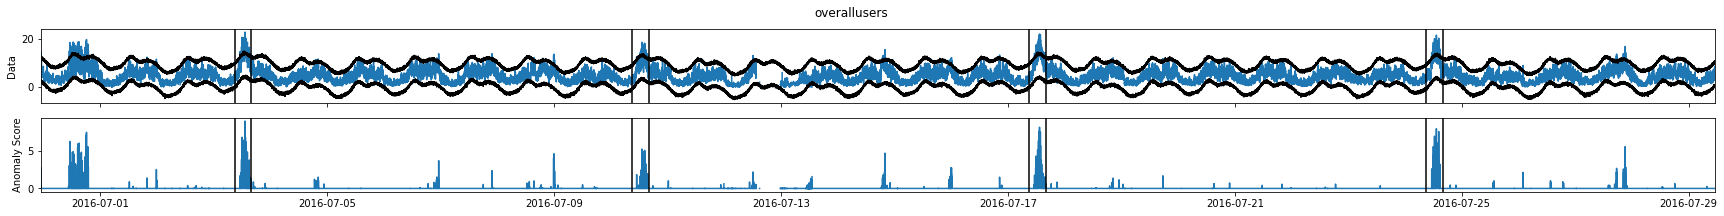

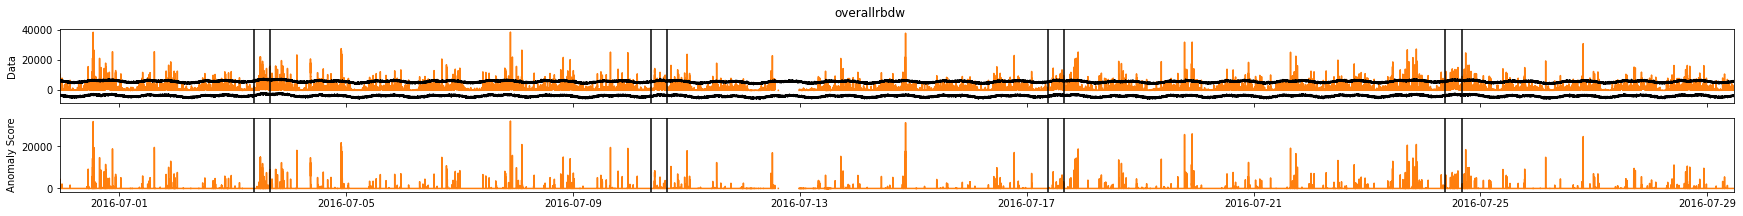

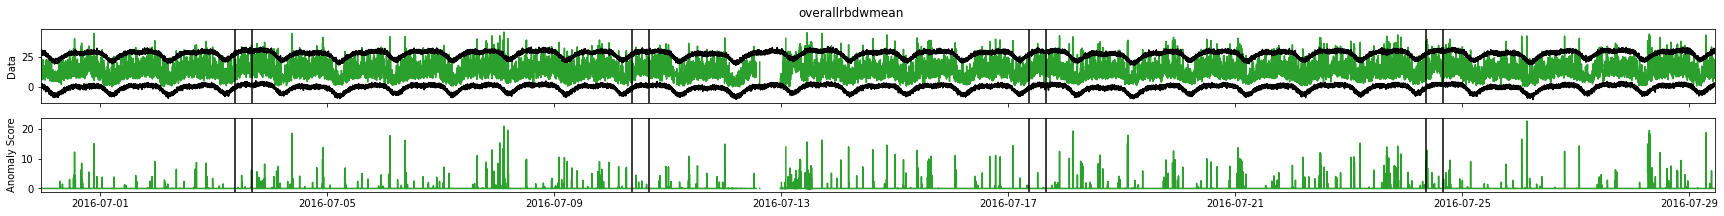

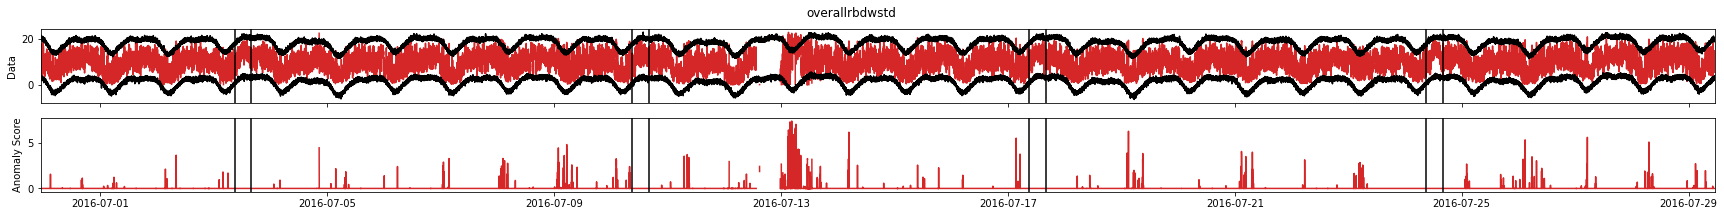

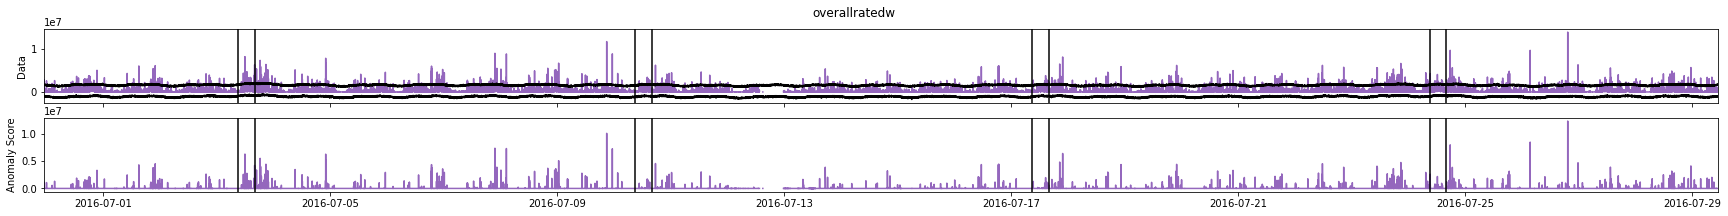

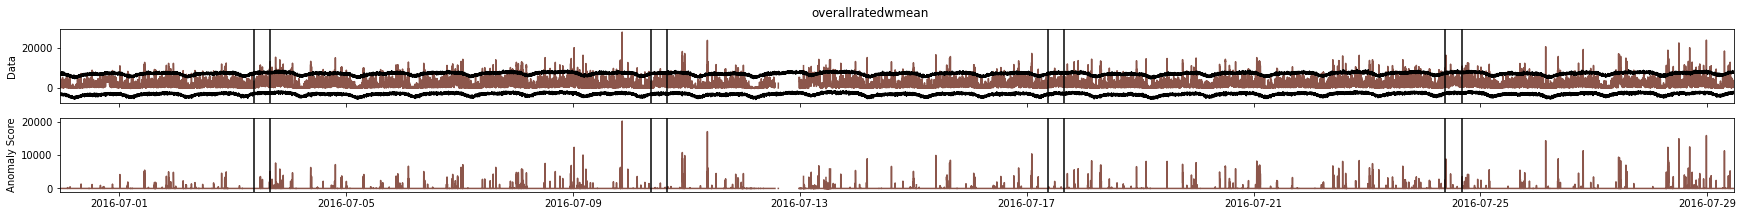

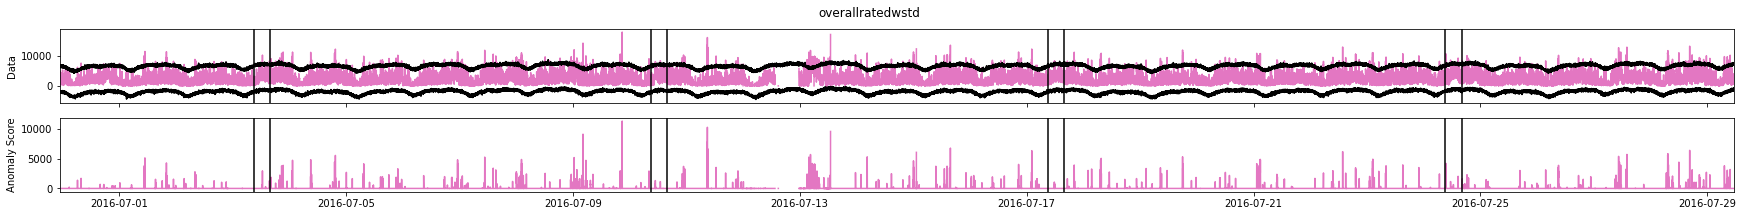

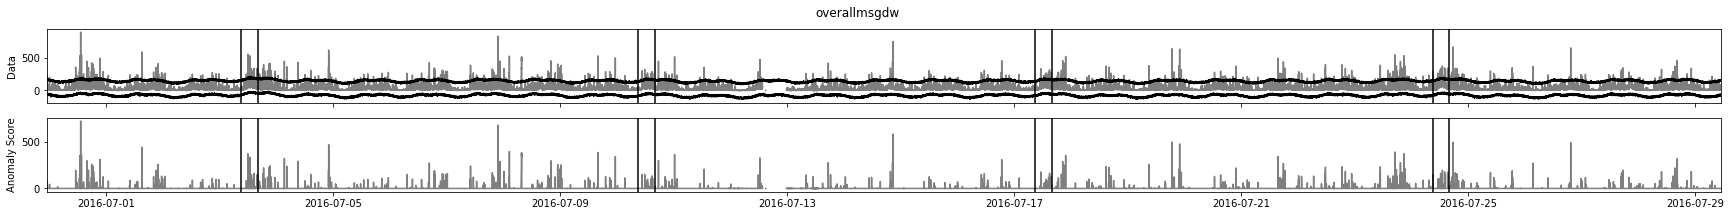

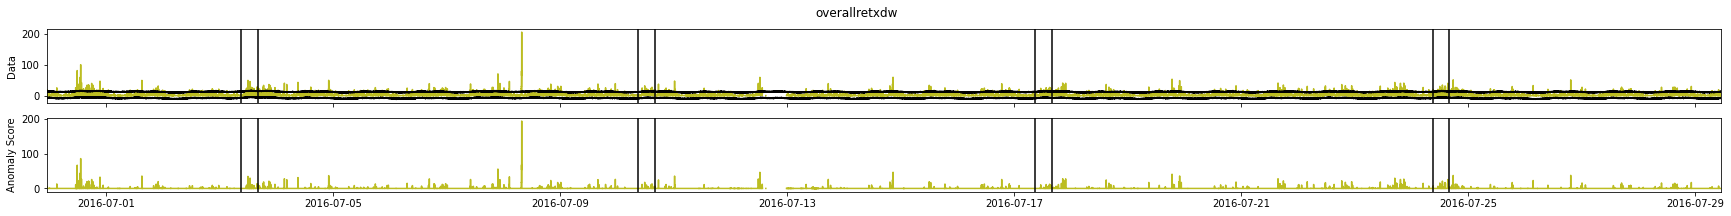

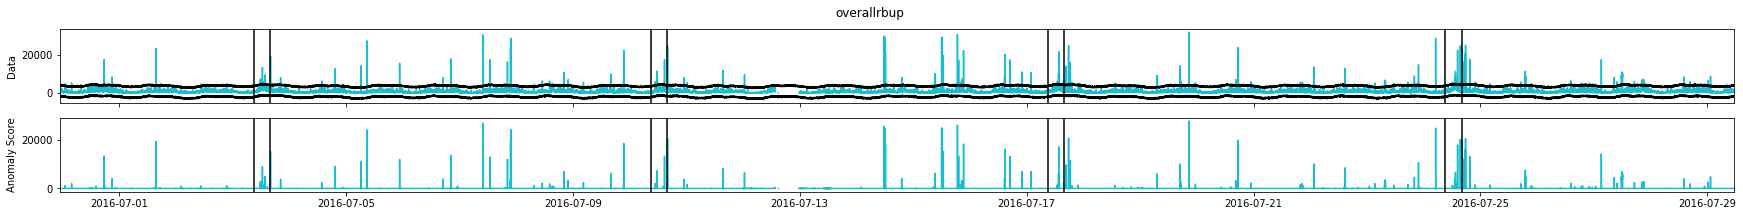

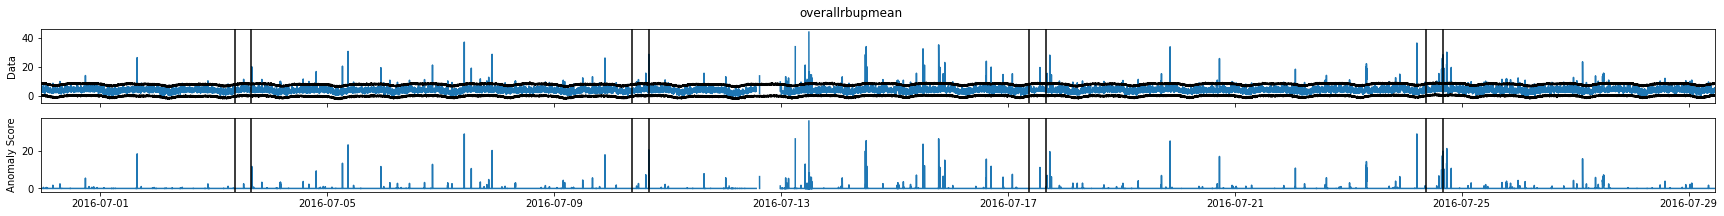

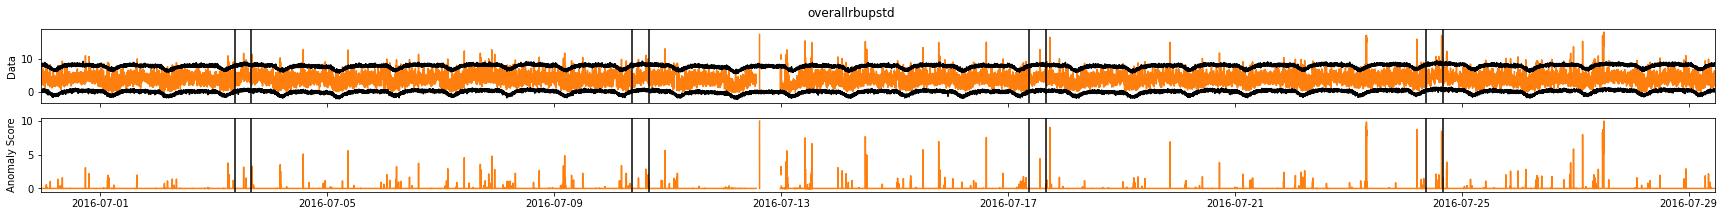

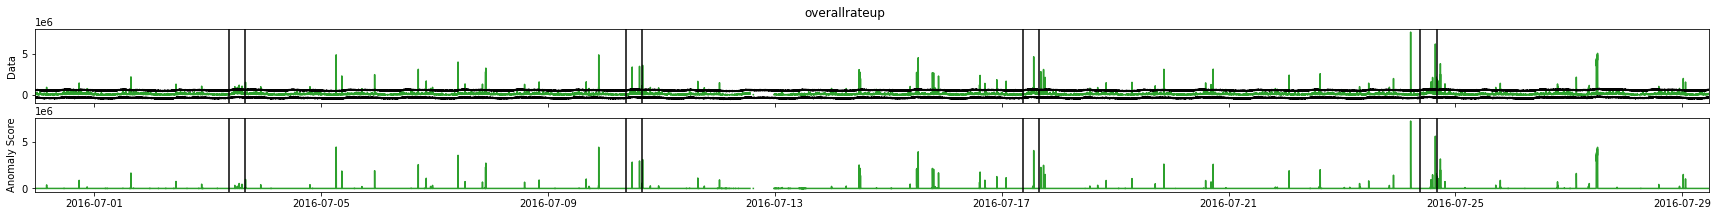

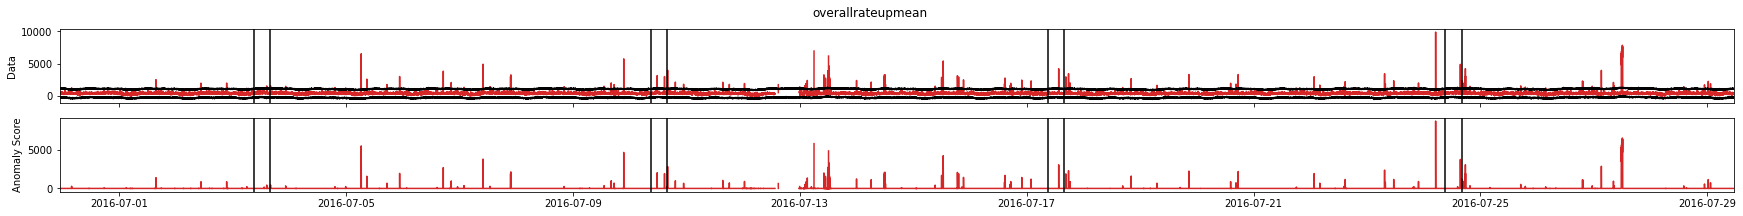

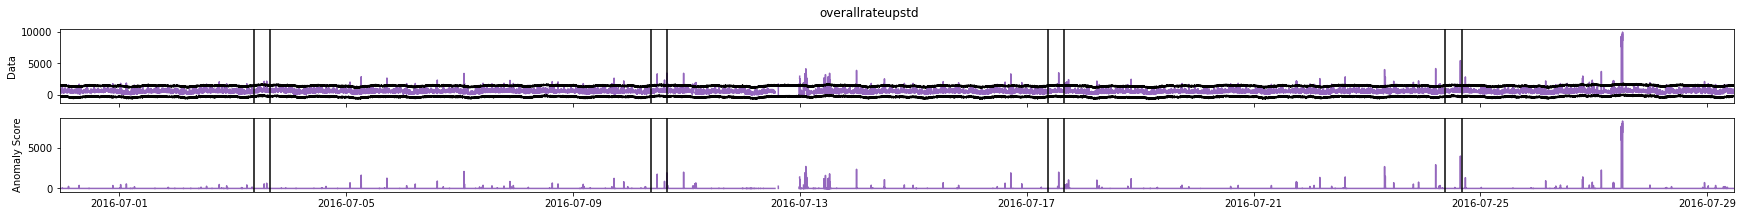

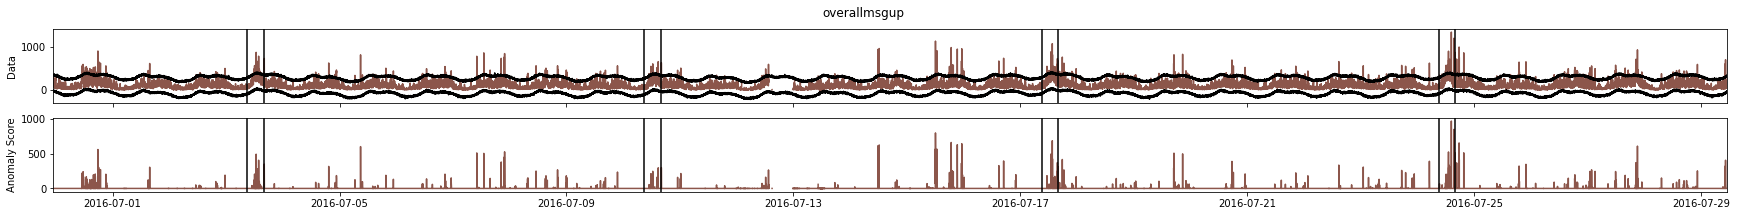

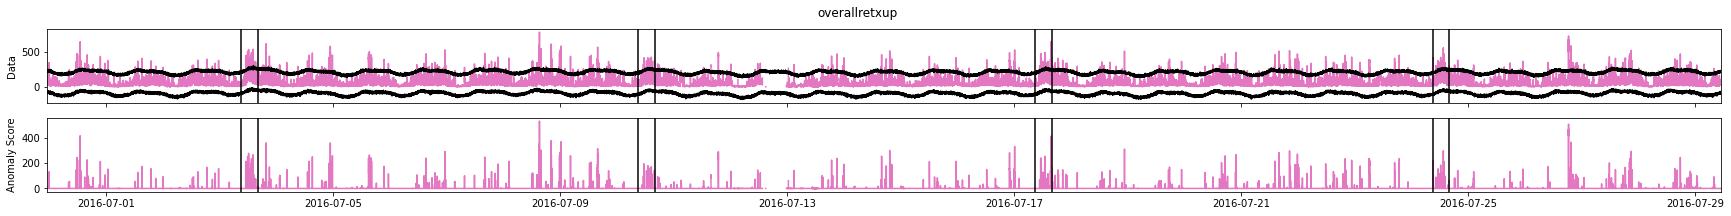

In [8]:
colors = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

for (col,df),c in zip(res.items(), colors):
    _ = make_plot(df, col, c=c)
    plt.show()

In [9]:
dfs = []

for col, df in res.items():
    df = df[["anomaly"]].rename(columns={"anomaly":f"{col}_prophet"})
    dfs.append(df)

In [10]:
df_anomaly = pd.concat(dfs, axis=1)
df_anomaly.head()

,overallusers_prophet,overallrbdw_prophet,overallrbdwmean_prophet,overallrbdwstd_prophet,overallratedw_prophet,overallratedwmean_prophet,overallratedwstd_prophet,overallmsgdw_prophet,overallretxdw_prophet,overallrbup_prophet,overallrbupmean_prophet,overallrbupstd_prophet,overallrateup_prophet,overallrateupmean_prophet,overallrateupstd_prophet,overallmsgup_prophet,overallretxup_prophet
overalltime,,,,,,,,,,,,,,,,,
2016-06-29 22:56:00,0.000000,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-29 22:57:00,0.000000,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-29 22:58:00,2.794494,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-29 22:59:00,0.000000,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-29 23:00:00,0.000000,4521.494836,0.0,0.0,1.172542e+06,0.0,0.0,86.540913,5.143946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df_anomaly.to_csv("../anomaly/prophet.tar.gz", index=True)